# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [7]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(1)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([0.5402])
Addition: tensor([1.5402, 2.5402, 3.5402])
Mean: tensor(2.)


## Autograd Basics

In [8]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [9]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 1, 64, 64) > 0).float()  # fake mask
        image_resize=torch.nn.functional.interpolate(image,(128,128),mode="bilinear",align_corners=False)
        mask_resize=torch.nn.functional.interpolate(mask,(128,128),mode="nearest")
        return image_resize.squeeze(0), mask_resize.squeeze(0)

dataset = RandomMRIDataset()
img, msk = dataset[5]
img.shape, msk.shape,dataset.length


(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), 100)

## DataLoader

In [10]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 128, 128])


## Building a Simple CNN

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model(img.unsqueeze(0)))


tensor([[0.4953]], grad_fn=<SigmoidBackward0>)


## Training Loop Example

In [12]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [13]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [15]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ec1=conv_block(1,32)
        self.ec2=conv_block(32,64)
        self.ec3=conv_block(64,128)

        self.pipe=nn.Conv2d(128,256,3,padding=1)

        self.upc1=nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec1=conv_block(256,128)

        self.upc2=nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec2=conv_block(128,64)

        self.upc3=nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec3=conv_block(64,32)

        self.fin=nn.Conv2d(32,1,1)

    def forward(self, x):
        
        enc1=self.ec1(x)
        x=nn.MaxPool2d(2)(enc1)
        enc2=self.ec2(x)
        x=nn.MaxPool2d(2)(enc2)
        enc3=self.ec3(x)
        x=nn.MaxPool2d(2)(enc3)

        x=self.pipe(x)

        x=self.upc1(x)
        x=torch.cat([x,enc3],dim=1)
        x=self.dec1(x)

        x=self.upc2(x)
        x=torch.cat([x,enc2],dim=1)
        x=self.dec2(x)

        x=self.upc3(x)
        x=torch.cat([x,enc1],dim=1)
        x=self.dec3(x)

        x=self.fin(x)

        return x


In [17]:
def Diceloss(pred,target):

    pred=torch.sigmoid(pred)
    pred=pred.view(-1)
    target=target.view(-1)

    intersection=(pred*target).sum()

    dice=(2.*intersection+1e-7)/(pred.sum()+target.sum()+1e-7)

    return 1-dice



In [23]:
model=MiniUNet()
optimizer=optim.Adam(model.parameters(),1e-3)
lossarr=[]
lossavg=[]

for i in range(5):
    losstemp=[]
    for images,masks in loader:
        optimizer.zero_grad()
        preds=model(images)
        loss=Diceloss(preds,masks)
        lossarr.append(loss.item())
        losstemp.append(loss.item())
        loss.backward()
        optimizer.step()
    lossavg.append(np.mean(losstemp))
    print("Epoch:",i+1)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


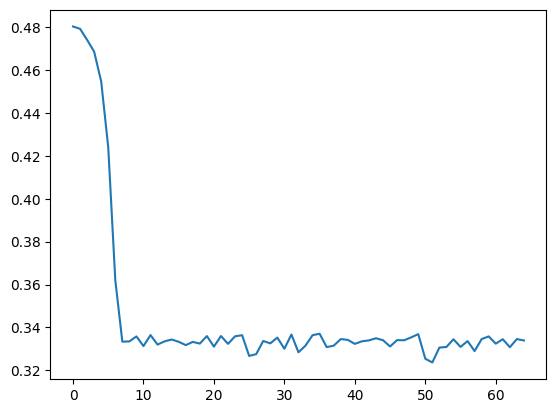

In [27]:
plt.plot(lossarr)

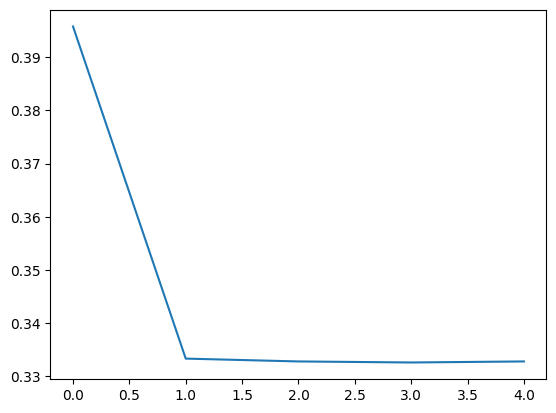

In [26]:
plt.plot(lossavg)
plt.show()
